In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [28]:
## CONSTANTS
RAW_DIR='data/raw'
BAD_DIR='data/cor_data'
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
EPOCHS = 10
SEED=42


In [13]:
## load dataset and check the corrupted images if exist and remove them

def check_corrupted_images(raw_data_dir, corrupt_dir, img_height, img_width):
    ##creat the directory to store corrupted images
    os.makedirs(corrupt_dir, exist_ok=True)

    ##walk through the raw data directory
    for cur_dir, dirs, files in os.walk(raw_data_dir):
        ##iterate through each files encountered on each directory
        for file in files:
            ##process only images which has correct extensions
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue
            ##construct the full file path 
            file_path = os.path.join(cur_dir, file)

            ##considering files are initially not corrupted
            corrupted=False

            ##PIL checks
            # This catches header corruption and truncated files
            try:
                with Image.open(file_path) as img_file:
                    img_file.verify()
                # Re-open the image to fully load pixel data
                # verify() does not load pixels, so this step is required
                with Image.open(file_path) as img:
                    img.load()
            except Exception:
                # If any Pillow operation fails, mark the image as corrupted
                corrupted=True
    
            ##TensorFlow check
            #this code ensures the compatibility of the image with Tensorflow 
            if not corrupted:
                try:
                    ##read the image file
                    img_raw = tf.io.read_file(file_path)
                    ##decode the image file, expand_animations=False prevents GIF-related issues
                    img_decoded = tf.image.decode_image(img_raw, expand_animations=False)
                    ##resize the image to expected dimensions
                    img_resized = tf.image.resize(img_decoded, (img_height, img_width))
                    ##If the image is corrupted, this code crashes
                    _= tf.cast(img_resized, tf.uint8)
                except Exception:
                    ##If any TensorFlow operation fails, mark the image as corrupted
                    corrupted=True

            if corrupted:
                shutil.move(file_path, os.path.join(corrupt_dir, file))
                print(f'Moving the corrupted image: {file_path}')                     
            

In [9]:
##checking the corrupted images
check_corrupted_images(RAW_DIR,BAD_DIR,IMG_HEIGHT,IMG_WIDTH)

In [10]:
##loading data into working directory
raw_data = tf.keras.preprocessing.image_dataset_from_directory(
    RAW_DIR,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 75000 files belonging to 5 classes.


In [11]:
##class names
class_names = raw_data.class_names
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

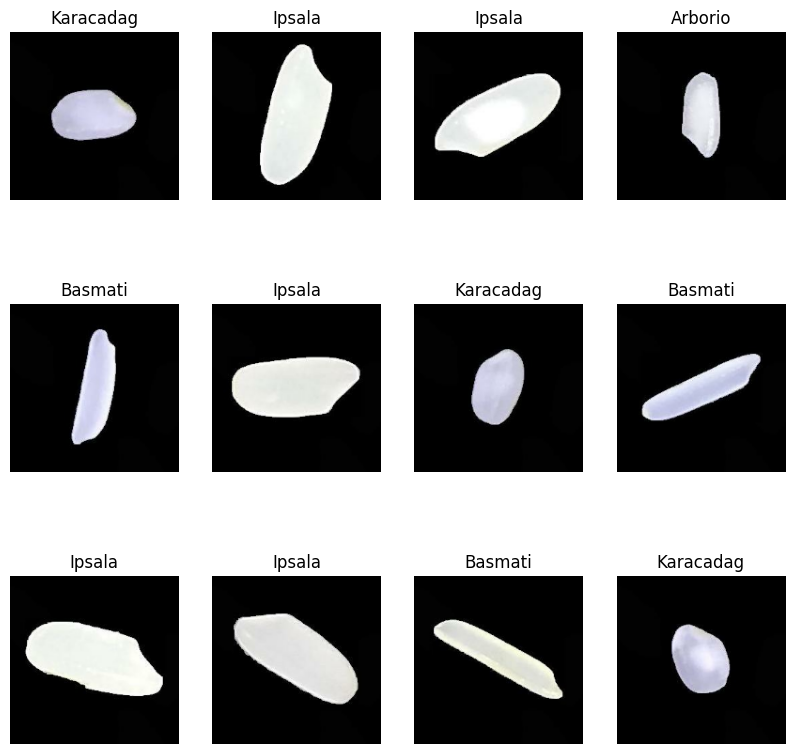

In [27]:
##display some images from the dataset
plt.figure(figsize=(10,10))
for image, label in raw_data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(np.array(image[i]).astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
plt.show()

In [31]:
##data splitting into training, validation and test sets
def data_splitter(raw_dataset, 
                  train_split_size=.80,
                  val_split_size=0.10,
                  shuffle=True,
                  shuffle_size=1000):
    ##get the total number of data
    total_number_data= len(raw_dataset)

    if shuffle:
        raw_dataset=raw_dataset.shuffle(shuffle_size, SEED)
    ##calculate the splitted data based on its respective splitting size
    train_data_number=int(train_split_size*total_number_data)
    val_data_number=int(val_split_size*total_number_data)

    ##splitted data
    train=raw_dataset.take(train_data_number)
    val=raw_dataset.skip(train_data_number).take(val_data_number)
    test=raw_dataset.skip(train_data_number).skip(val_data_number)

    return train, val, test

In [32]:
##splitting the dataset
train_ds, val_ds, test_ds = data_splitter(raw_data)

In [35]:
len(train_ds), len(val_ds), len(test_ds)

(1875, 234, 235)